# Documentation.ipynb
This is an documentation notebook to show off the capabillities of Genshin Artifact Scouter (GAS).

### Helpful starting settings

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
import os
import logging
import logging.config

config_path = os.path.join(os.path.abspath(''), "config/logging.conf") 
logging.config.fileConfig(config_path)
logging.info("Logging initialized.")
display(HTML("<style>.container { width:70% !important; }</style>"))

2021-08-22 23:36:31 - INFO - Logging initialized.


## Importing Source Code
The following code imports the Python modules used to run GAS. They must be included at the top of every notebook to use them. `genshin_data` will log that data is being imported and calculated. On the first time this script is run, it will download data files from external sources.

In [3]:
from src import evaluate, potential, genshin_data
from src.artifact import Circlet, Flower, Goblet, Plume, Sands
from src.artifacts import Artifacts
from src.character import Character
from src.go_parser import GenshinOptimizerData
from src.weapon import Weapon

2021-08-22 23:36:31 - INFO - Importing and calculating data...
2021-08-22 23:36:31 - INFO - Data imported and calcualted.


## Importing from Genshin Optimizer
This code was designed to function as an offshoot of the great Genshin Optimizer tool by frzyc: https://frzyc.github.io/genshin-optimizer/. GAS can automatically import characters, weapons, and artifacts straight from GO data. Even if you do not use Genshin Optimizer, it is easier to define characters, weapons, and artifacts in GO and import them into GAS than to define them yourself in GAS.

To import from GO, you must first download your data from GO from https://frzyc.github.io/genshin-optimizer/#/setting. This will appear in a .json format. Then, copy that data somewhere it is accessable by this notebook. If you are using Jupyter in a web browser, this can be done by going to File > Open (opens a new tab) > Upload. I have provided my data as a sample in ./data/sample_go_data.json.

Import your GO data into GAS by passing the following command on the path to your GO data.

In [4]:
go_data = GenshinOptimizerData("data/sample_go_data.json")

2021-08-22 23:36:31 - INFO - Reading Genshin Optimizer data from data/sample_go_data.json...
2021-08-22 23:36:31 - INFO - Characters imported successfully.
2021-08-22 23:36:31 - INFO - Artifacts imported successfully.


 Let's take a look at what has been imported.

In [5]:
# List of all characters imported
go_data.characters

{'xingqiu': <src.character.Character at 0x16889b84a60>,
 'noelle': <src.character.Character at 0x16889b847c0>,
 'barbara': <src.character.Character at 0x168a77dc070>,
 'tartaglia': <src.character.Character at 0x168a7881250>,
 'qiqi': <src.character.Character at 0x168a7881eb0>,
 'fischl': <src.character.Character at 0x168a7881e80>,
 'mona': <src.character.Character at 0x168a78817c0>,
 'albedo': <src.character.Character at 0x168a7881d00>,
 'klee': <src.character.Character at 0x168a7881d90>,
 'sucrose': <src.character.Character at 0x168a78814f0>,
 'diona': <src.character.Character at 0x168a7881400>,
 'beidou': <src.character.Character at 0x168a78811f0>,
 'venti': <src.character.Character at 0x168a7881c40>,
 'eula': <src.character.Character at 0x168a78817f0>,
 'diluc': <src.character.Character at 0x168a7881520>,
 'yanfei': <src.character.Character at 0x168a7881850>,
 'xiangling': <src.character.Character at 0x168a78812e0>,
 'ningguang': <src.character.Character at 0x1688ab373d0>,
 'ganyu':

In [6]:
# Retrieve Ganyu
ganyu = go_data.get_character("Ganyu")
ganyu.name

'ganyu'

In [7]:
# Look at Ganyu's level
ganyu.level

80

In [8]:
# Look at Ganyu's stats
ganyu.base_ATK

311.3103343406219

In [9]:
# Look at Ganyu's weapon
weapon = ganyu.weapon
weapon.name

'PrototypeCrescent'

In [10]:
# Retrieve Ganyu's artifacts
ganyu_artifacts = go_data.get_characters_artifacts("Ganyu")
ganyu_artifacts.flower.substats

{'Crit Rate%': 6.2, 'Crit DMG%': 12.4, 'HP%': 9.9, 'DEF%': 11.7}

## Object Types
GAS creates 4 core object types: Character, Weapon, Artifact, and Artifacts. If you really want to, you can define them all manually, but I highly recomend you just make them in GO and import them.

### Characters
Characters are created from the following parameters:
- **name** (str): Name of the character. This is used to determine the base stat scaling of the character by comparing to the stats database.
- **level** (int) and **ascension** (int): Current level and ascension of the character, used to calculate the current stats of the character.
- **dmg_type** (str): The kind of "damage" the character deals, either `"Physical"`, `"Elemental"`, or `"Healing"`, which determines whether `"Physical DMG%"`, `"Elemental DMG%"`, or `"Healing Bonus%"` applies to power calculations. There is currently no distinction in the code between different types of Elemental Damages. If imported from GO, defaults to `"Elemental"`.
- **passive** (dict): Dictionary of additional passive abillities beyond base stats and ascension stats (i.e. Keqing Crit DMG%). Passives are not automatically generated and must be supplied manually, even if using GO import. Passive keys are valid stat strings while values are the corresponding stat increase.
- **weapon** (Weapon): Weapon object equipped to character. Weapons can be supplied at instantiation or later, as shown later in this documentation. Evaluation will not function if character does not have a weapon.
- **scaling_stat** (str): Stat the character scales with, either `"ATK"`, `"DEF"` or `"HP"`. Slip or dual scalling is not implemented. Defaults to `"ATK"` if not defined or imported from GO.
- **crits** (str): Whether to apply cits as averages (`"avgHit"`), always crit (`"critHit"`), or never crit (`"hit"`). Defaults to `"avgHit"` if not supplied or to setting used in GO if imported.
- **amplifying_reaction** (str): Type of amplifying reaction used: `"hydro_vaporize"`, `"pyro_vaporize"`, `"pyro_melt"`, `"cryo_melt"` or `"none"`. Default `"None"` if not provided or to reaction setting used in GO if imported.
- **reaction_percentage** (float): Percentage of attacks that result in an amplifying reaction, range of `0.0`% to `100.0`%. Linearly scales damage between if there were no amplifying reactions to if there were only amplifying reaction. Default `0.0`% if reaction is `"None"` or `100.0`% otherwise.

Characters are equipped with specific weapons but are not equipped with specific artifacts. This is so that one character can be evaluated against a variety of different artifacts but with the same weapon.

In [11]:
keqing_manual = Character(
    name="keqing",
    level=80,
    ascension=6,
    dmg_type="Elemental"
)
keqing_manual.passive = {
    "Crit Rate%": 15.0
}
keqing_manual.scaling_stat = "ATK"
keqing_manual.crits = "avgHit"
keqing_manual.amplifying_reaction = "none"
# The following line doesn't matter because amplifying_reaction = "none"
keqing_manual.reaction_percentage = 0.0

Let us fix the Ganyu that we imported from GO since it does not include the passive Elemental DMG% from being in her ult and the 15% and the extra 20% Crit Rate% for Frostflake Arrows after her first. If we wanted to evaluate only her first Frostflake Arrow or when she is not in her ult's radius, we would not include these passives.

In [12]:
ganyu.passive = {
    "Elemental DMG%": 15.0,
    "Crit Rate%": 20.0
}

### Weapons
Weapons are created with the following parameters:
- **name** (str): Name of the weapon. This is used to determine the base stat scaling of the weapon by comparing to the stats database.
- **level** (int) and **ascension** (int): Current level and ascension of the weapon, used to calculate the current stats of the weapon.
- **passive** (dict): Dictionary of additional passive abilities beyond base stats and ascension stats (i.e. Keqing Crit DMG%). Passives are not automatically generated and must be supplied manually, even if using GO import. Passive keys are valid stat strings while values are the corresponding stat increase.

In [13]:
lions_roar_manual = Weapon(
    name="Lions Roar",
    level=90,
    ascension=6,
    # Refinement 5
    passive={
        "DMG%": 32.0
    }
)
lions_roar_manual.stats

Base HP                0.000000
Base ATK             509.605962
Base DEF               0.000000
HP                     0.000000
ATK                    0.000000
DEF                    0.000000
HP%                    0.000000
ATK%                  41.346000
DEF%                   0.000000
Physical DMG%          0.000000
Elemental DMG%         0.000000
DMG%                  32.000000
Elemental Mastery      0.000000
Energy Recharge%       0.000000
Crit Rate%             0.000000
Crit DMG%              0.000000
Healing Bonus%         0.000000
probability            0.000000
dtype: float64

In [14]:
keqing_manual.weapon = lions_roar_manual
keqing_manual.stats

Base HP              12182.017519
Base ATK               809.798054
Base DEF               743.109007
HP                       0.000000
ATK                      0.000000
DEF                      0.000000
HP%                      0.000000
ATK%                    41.346000
DEF%                     0.000000
Physical DMG%            0.000000
Elemental DMG%           0.000000
DMG%                    32.000000
Elemental Mastery        0.000000
Energy Recharge%         0.000000
Crit Rate%              20.000000
Crit DMG%               88.400000
Healing Bonus%           0.000000
probability              0.000000
dtype: float64

Let us fix Ganyu's Prototype Cresent that we imported from GO since it doesn't include the all important ATK% bonus for headshots. We are going to presume that passive is active for our analysis.

In [15]:
ganyu.weapon.passive = {
    # Refinement 5
    "ATK%": 72.0
}

### Artifact
Artifacts must be constructured from their respective slot constructor: `Flower()`, `Plume()`, `Sands()`, `Goblet()`, or `Circlet()`. Artifact are created with the following parameters:
- **main_stat** (str): Main stat for artifact. Main stat must be compatable with the artifact slot, i.e. you cannot have a Elemental DMG% Flower.
- **stars** (int): Number of stars
- **level** (int): Level of artifact, must not exceede stars limited by `stars`.
- **set_str** (str): Set associated with artifact.
- **substats** (dict[str, float]): Dictionary of substats, keyed to substat string with value as substat value. 

In [16]:
sands = Sands(
    main_stat="ATK%",
    stars=5,
    level=0,
    set_str="gladiators",
    substats={
        "ATK": 18,
        "HP%": 4.6,
        "Elemental Mastery": 21
    }
)
sands.stats

Base HP               0.0
Base ATK              0.0
Base DEF              0.0
HP                    0.0
ATK                  18.0
DEF                   0.0
HP%                   4.6
ATK%                  7.0
DEF%                  0.0
Physical DMG%         0.0
Elemental DMG%        0.0
DMG%                  0.0
Elemental Mastery    21.0
Energy Recharge%      0.0
Crit Rate%            0.0
Crit DMG%             0.0
Healing Bonus%        0.0
probability           0.0
dtype: float64

### Artifacts
An "Artifacts" object represents a set of artifact objects, including up to one of each `Flower()`, `Plume()`, `Sands()`, `Goblet()`, and `Circlet()`. Artifacts are created with the following parameters:
- **artifacts** (list[Artifact]): List of artifacts to equip. Can include either 0 or 1 of each artifact type.
- **use_set_bonus** (bool): Flag for whether to factor set bonuses into stats, defaults to True if not provided.

In [17]:
flower = Flower(main_stat="HP", stars=5, level=0, set_str="gladiators", substats={})
plume = Plume(main_stat="ATK", stars=5, level=0, set_str="noblesse", substats={})
goblet = Goblet(main_stat="Elemental DMG%", stars=5, level=0, set_str="noblesse", substats={})
circlet = Circlet(main_stat="Crit Rate%", stars=5, level=0, set_str="witch", substats={})

artifacts = Artifacts(artifacts=[flower, plume, sands, goblet, circlet], use_set_bonus=True)
artifacts.stats

Base HP                0.0
Base ATK               0.0
Base DEF               0.0
HP                   717.0
ATK                   65.0
DEF                    0.0
HP%                    4.6
ATK%                  25.0
DEF%                   0.0
Physical DMG%          0.0
Elemental DMG%         7.0
DMG%                  20.0
Elemental Mastery     21.0
Energy Recharge%       0.0
Crit Rate%             4.7
Crit DMG%              0.0
Healing Bonus%         0.0
probability            0.0
dtype: float64

## Evaluate

### Stats
Once you have a character with a weapon and an artifacts object, you can calculate the stats of all the components together

In [18]:
evaluate.evaluate_stats(character=ganyu, artifacts=ganyu_artifacts)

Base HP              9108.050365
Base ATK              820.916297
Base DEF              585.912861
HP                   5706.000000
ATK                   338.000000
DEF                    16.000000
HP%                    30.300000
ATK%                  189.146000
DEF%                   21.900000
Physical DMG%           0.000000
Elemental DMG%         76.600000
DMG%                    0.000000
Elemental Mastery      16.000000
Energy Recharge%       37.000000
Crit Rate%             83.200000
Crit DMG%             181.700000
Healing Bonus%          0.000000
probability             0.000000
dtype: float64

### Power
Power is a target agnostic measure of the "strength" of a character. It does take into account the scaling stats shown above, but does not take into affect the scaling due to talent level, character vs target level, target DEF, or target RES. Since the objective of this tool is to relativistically compare artifacts to each other, this is not an issue as these effects would apply equally between artifacts. If you are looking for raw damage numbers, I recomend using Genshin Optimizer.

In [19]:
evaluate.evaluate_power(character=ganyu, artifacts=ganyu_artifacts)

12028.159212735147

## Slot Potential
Slot potential evaluates the range of possible 

2021-08-22 23:36:32 - INFO - --------------------------------------------------------------------------------------------------------------
2021-08-22 23:36:32 - INFO - Evaluating potential of Plume slot...
2021-08-22 23:36:32 - INFO - CHARACTER: Ganyu, 80/90
2021-08-22 23:36:32 - INFO - WEAPON: Prototype Crescent, 90/90
2021-08-22 23:36:32 - INFO - ARTIFACT:
2021-08-22 23:36:32 - INFO -   Plume 5*        Blizard 20/20               ATK:  311
2021-08-22 23:36:32 - INFO - EQUIPPED ARTIFACTS:                                       HP  ATK  DEF  HP% ATK% DEF%   EM  ER%  CR%  CD%
2021-08-22 23:36:32 - INFO -  Flower 5*        Blizard 20/20                HP: 4780                 9.9      11.7            6.2 12.4
2021-08-22 23:36:32 - INFO -   Sands 5*        Blizard 20/20              ATK%: 46.6             16           10.2            5.4 18.7
2021-08-22 23:36:32 - INFO -  Goblet 5*      Wanderers 20/20    Elemental DMG%: 46.6  478   27       9.9 14.0                         
2021-08-22 23

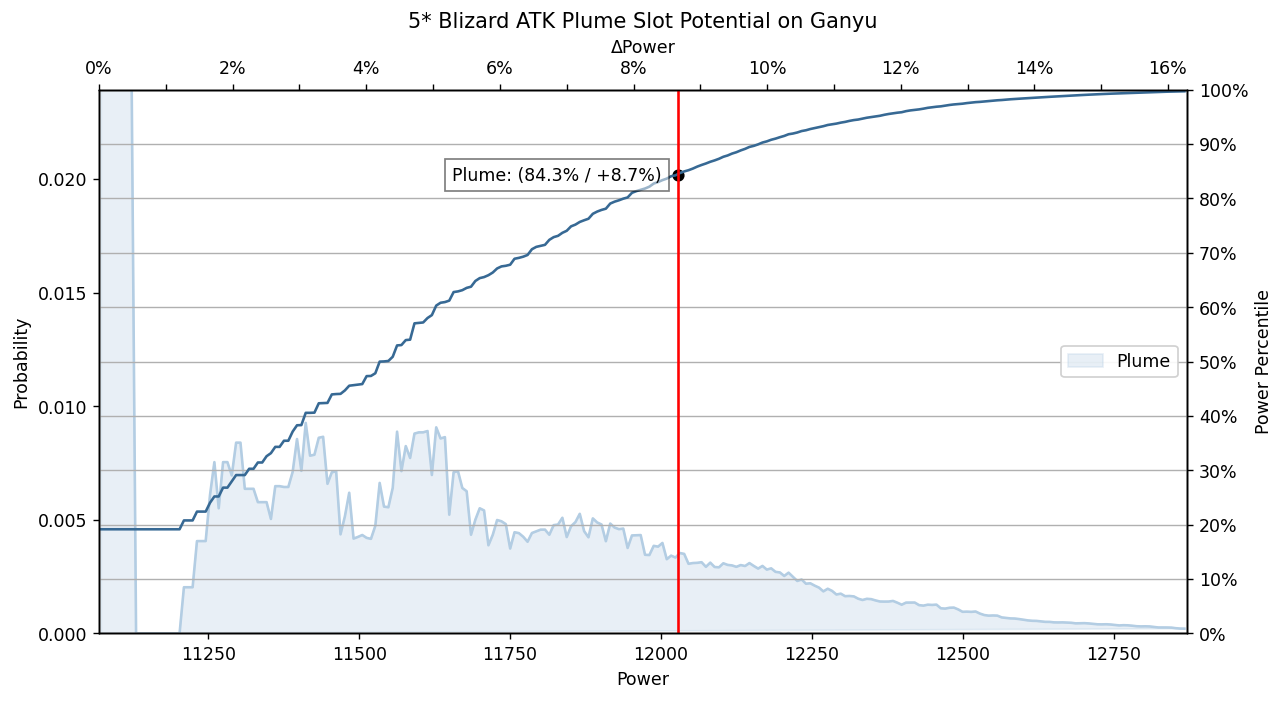

In [20]:
slot_potentials = potential.slot_potential(character=ganyu, equipped_artifacts=ganyu_artifacts, slot=Plume, plot=True)

In [21]:
# slot_potentials = potential.slot_potential(character=ganyu, equipped_artifacts=ganyu_artifacts, slot=Plume, plot=True, smooth=True)

In [22]:
# slot_potentials = potential.all_slots_potentials(character=ganyu, equipped_artifacts=ganyu_artifacts, plot=True)

## Ploting
TODO

## Stats

NOTE: Percentage stats (`"ATK%"`, `"Crit Rate%"`, etc) are scaled based on human readable percentages, such that `18.0` = `18%`. 

**Valid Passive Stats**

`"Base HP"`, `"Base ATK"`, `"Base DEF"`, `"HP"`, `"ATK"`, `"DEF"`, `"HP%"`, `"ATK%"`, `"DEF%"`, `"Elemental Mastery"`, `"Energy Recharge%"`, `"Crit Rate%"`, `"Crit DMG%"`, `"Physical DMG%"`, `"Elemental DMG%"`, `"DMG%"`, `"Healing Bonus%"`

**Valid Main Stats**

`Flower()`: `"HP"`

`Plume()`: `"ATK"`

`Sands()`: `"HP%"`, `"ATK%"`, `"DEF%"`, `"Elemental Mastery"`, `"Energy Recharge%"`

`Goblet()`: `"HP%"`, `"ATK%"`, `"DEF%"`, `"Elemental Mastery"`, `"Elemental DMG%"`, `"Physical DMG%"`

`Circlet()`: `"HP%"`, `"ATK%"`, `"DEF%"`, `"Elemental Mastery"`, `"Crit Rate%"`, `"Crit DMG%"`, `"Healing Bonus%"`

**Valid Substats**

`"HP"`, `"ATK"`, `"DEF"`, `"HP%"`, `"ATK%"`, `"DEF%"`, `"Elemental Mastery"`, `"Energy Recharge%"`, `"Crit Rate%"`, `"Crit DMG%"`

**Valid Sets**

`"initiate"`, `"adventurer"`, `"lucky"`, `"doctor"`, `"resolution"`, `"miracle"`, `"berserker"`, `"instructor"`, `"exile"`, `"defenders"`, `"brave"`, `"martial"`, `"gambler"`, `"scholar"`, `"illumination"`, `"destiny"`, `"wisdom"`, `"springtime"`, `"gladiators"`, `"wanderers"`, `"thundersoother"`, `"thundering"`, `"maiden"`, `"viridescent"`, `"witch"`, `"lavawalker"`, `"noblesse"`, `"chivalry"`, `"petra"`, `"bolide"`, `"blizard"`, `"depth"`, `"millelith"`, `"pale"`, `"emblem"`, `"reminiscence"`, `""`

**Set Bonuses**
`"initiate"`:       `[{}, {}]`

`"adventurer"`:     `[{"HP": 1000}, {}]`

`"lucky"`:          `[{"DEF": 100}, {}]`

`"doctor"`:         `[{"Healing Bonus%": 20.0}, {}]`

`"resolution"`:     `[{"ATK%": 18.0}, {"Crit Rate%": 30.0}]`

`"miracle"`:        `[{}, {}]`

`"berserker"`:      `[{"Crit Rate%": 12.0}, {}]`

`"instructor"`:     `[{"Elemental Mastery": 80}, {"Elemental Mastery": 120}]`

`"exile"`:          `[{"Energy Recharge%": 20.0}, {}]`

`"defenders"`:      `[{"DEF%": 30.0}, {}]`

`"brave"`:          `[{"ATK%": 18.0}, {"DMG%": 15.0}]`

`"martial"`:        `[{"DMG%": 15.0}, {"DMG%": 25.0}]`

`"gambler"`:        `[{"DMG%": 20.0}, {}]`

`"scholar"`:        `[{"Energy Recharge%": 20.0}, {}]`

`"illumination"`:   `[{}, {}]`

`"destiny"`:        `[{}, {}]`

`"wisdom"`:         `[{}, {}]`

`"springtime"`:     `[{}, {}]`

`"gladiators"`:     `[{"ATK%": 18.0}, {"DMG%": 35.0}]`

`"wanderers"`:      `[{"Elemental Mastery": 80}, {"DMG%": 35.0}]`

`"thundersoother"`: `[{}, {"DMG%": 35.0}]`

`"thundering"`:     `[{"Elemental DMG%": 15.0}, {}]`

`"maiden"`:         `[{"Healing Bonus%": 15.0}, {"Healing Bonus%": 20.0}]`

`"viridescent"`:    `[{"Elemental DMG%": 15.0}, {}]`

`"witch"`:          `[{"Elemental DMG%": 15.0}, {"DMG%": 15.0}]`

`"lavawalker"`:     `[{}, {"DMG%": 35.0}]`

`"noblesse"`:       `[{"DMG%": 20.0}, {}]`

`"chivalry"`:       `[{"Physical DMG%": 25.0}, {"DMG%": 50.0}]`

`"petra"`:          `[{"Elemental DMG%": 15.0}, {}]`

`"bolide"`:         `[{}, {"DMG%": 40.0}]`

`"blizard"`:        `[{"Elemental DMG%": 15.0}, {"Crit Rate%": 40.0}]`

`"depth"`:          `[{"Elemental DMG%": 15.0}, {"DMG%": 30.0}]`

`"millelith"`:      `[{"HP%": 20.0}, {"ATK%": 20.0}]`

`"pale"`:           `[{"Physical DMG%": 25.0}, {"ATK%": 18.0, 'Physical DMG%": 15.0}]`

`"emblem"`:         `[{"Energy Recharge%": 20.0}, {}]`

`"reminiscence"`:   `[{"ATK%": 18.0}, {"DMG%": 50.0}]`

`""`:               `[{}, {}]`